<a href="http://cocl.us/pytorch_link_top">
    <img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/notebook_images%20/Pytochtop.png" width="750" alt="IBM Product " />
</a> 

<img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/notebook_images%20/cc-logo-square.png" width="200" alt="cognitiveclass.ai logo" />

<h1>Non-linear encoder</h1> 

<h2>Table of Contents</h2>
<b>In this lab, we compare the ability of non-linear encoders to represent features better than linear encoders. This has applications in data visualization and clustering. We will illustrate this by visualizing the features of the 255-dimensional MIST dataset in a three-dimensional latent space.  We will see in the latent space that the samples are much better clustered with respect to each class using the Tanh function compared to the linear activation function. </p>

<ul>
<li><a href="#prep">Preparation</a></li>
<li><a href="#Load_Data">Load Data</a></li>
<li><a href="#AE">Differnt type of Autoencders/a></li>
</ul>
<p>Estimated Time Needed: <strong>25 min</strong></p>

<hr>

<!--Empty Space for separating topics-->

<h2 id="prep" >Preparation</h2>

Import the libraries we need to use in this lab.

In [1]:
# Using the following line code to install the torchvision library
# !conda install -y torchvision
!pip install Pillow==6.2.2
import torch 
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import matplotlib.pylab as plt
import numpy as np
import copy
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as colors
torch.manual_seed(7)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 28.4 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: Pillow
    Found existing installation: Pillow 8.1.0
    Uninstalling Pillow-8.1.0:
      Successfully uninstalled Pillow-8.1.0


Load the models form object storage:

In [2]:
!https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/DL0110EN/Version_3/Chapter_10/linear_visualization_MIST.pt
!https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/DL0110EN/Version_3/Chapter_10/tan_linear_out_visualization_MIST.pt
!https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/DL0110EN/Version_3/Chapter_10/auto_encoder_tanh_in_out.pt   

/bin/bash: https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/DL0110EN/Version_3/Chapter_10/linear_visualization_MIST.pt: No such file or directory
/bin/bash: https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/DL0110EN/Version_3/Chapter_10/tan_linear_out_visualization_MIST.pt: No such file or directory
/bin/bash: https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/DL0110EN/Version_3/Chapter_10/auto_encoder_tanh_in_out.pt: No such file or directory


This function will plot a PyTorch tensor as an image:

In [3]:
def show_data(data_sample, y=None):
    plt.imshow(data_sample[0].detach().numpy().reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')
    plt.show()

This function will plot the training cost and the validation metric. 

In [4]:
def plot_train_val(cost_list,accuracy_list,val_data_label ='accuracy'):

    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.plot(cost_list, color = color)
    ax1.set_xlabel('epoch ', color = color)
    ax1.set_ylabel('total loss', color = color)
    ax1.tick_params(axis = 'y', color = color)

    ax2 = ax1.twinx()  
    color = 'tab:blue'
    ax2.set_ylabel(val_data_label, color = color)  # we already handled the x-label with ax1
    ax2.plot(accuracy_list, color = color)
    ax2.tick_params(axis = 'y', color = color)
    fig.tight_layout()

The function will plot the output of the encoder of an autoencoder and colour code them with respect to the class of the MIST dataset. The activation must be 3D.

In [33]:
class plot_activations_3d():
    def __init__(self,model_,layer_name,dataset,tensor_size=256):
        """Plot activations of a  neal network and colour cots them with respect to class activaion must be 3D 

            arguments:
                model_:neral network model 
                layer_name:name of activation layer, must be  2D or 3D
                dataset:dataset object 
                tensor_size:size of input tensor       

            attributes:
                self.Y: class of each sample
                self.Z: (np.array): array of state-values obtained from policy evaluation function.
          
        """
        self.L=len(dataset)
        self.Z=np.ones((len(dataset),3))
        self.Y=np.ones(len(dataset))
        for n,(x,y) in enumerate(dataset): 
            z=torch.squeeze(getattr(model_,layer_name)(x.view(-1,tensor_size))).detach().numpy()
            self.Z[n,:]=z
            self.Y[n]=y    

    def plot(self, numbers=[0,1,2,3,4,5,6,7,8,9],scale=[1,1,1]):
        """
        number: list of classes to be plotted 
        scale: scale activations to plot better 
        """
        color_list=['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w','bx','rx']
        logic_array =np.zeros(self.L, dtype=bool)
        color_array=np.chararray(self.L,unicode=True)

        for number in numbers:
            logic_array=logic_array+(self.Y==number)
            color_array[self.Y==number]=color_list[number]


        fig=plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        plt.scatter(scale[0]*self.Z[logic_array,0],scale[1]*self.Z[logic_array,1],scale[2]*self.Z[logic_array,2],c=color_array)
        plt.show()

This function trains the autoencoder; the parameter <code>model</code> is the autoencoder object. The parameter  <code>train_loader</code> and <code>validation_loader</code> is the train loader and validation loader.  The Parameter optimizer is the optimizer object, and <code>n_epoch</code> is the number of epochs  

In [6]:
def train_model(model,train_loader,validation_loader,optimizer,n_epochs=4,checkpoint_path=None,checkpoint=None):   
    #global variable 
    cost_list_training =[]
    cost_list_validation =[]
    for epoch in range(n_epochs):
        cost_training=0
        for x, y in train_loader:
           
            model.train()
            optimizer.zero_grad()
            z = model(x.view(-1,256))
            loss = criterion(z, x.view(-1,256))
            loss.backward()
            optimizer.step()
            cost_training+=loss.data
        
        cost_list_training.append(cost_training)
    
       
        print("epoch {}, Cost {}".format(epoch+1,cost_training) )
        #perform a prediction on the validation  data  
        cost_val=0
        for x_test, y_test in validation_loader:
            
            model.eval()
            z = model(x_test.view(-1,256))
            loss = criterion(z, x_test.view(-1,256))
            cost_val+=loss.data
            
            
        
        cost_list_validation.append(cost_val)
        
        
        
    if checkpoint:
        checkpoint['epoch']=epoch
        checkpoint['model_state_dict']=model.state_dict()
        checkpoint['optimizer_state_dict']= optimizer.state_dict()
        checkpoint['loss']=loss 
        checkpoint['training_cost']=cost_list_training
        checkpoint['validaion_cost']=cost_list_validation
        torch.save(checkpoint, checkpoint_path)
     
    return cost_list_training, cost_list_validation

In [7]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')



    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



<h2 id="Load"> Load Data</h2> 

we create a transform to resize the image and convert it to a tensor :

In [8]:
IMAGE_SIZE = 16
tensor_size=IMAGE_SIZE*IMAGE_SIZE
composed = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), transforms.ToTensor()])

Load the training dataset by setting the parameters <code>train </code> to <code>True</code>. We use the transform defined above.

In [9]:
train_dataset = dsets.MNIST(root='./data', train=True, download=True, transform=composed)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Load the testing dataset by setting the parameters train  <code>False</code>.

In [10]:
# Make the validating 

validation_dataset = dsets.MNIST(root='./data', train=False, download=True, transform=composed)

We can see the data type is long.

In [12]:
# Show the data type for each element in dataset
train_dataset[0][1]

5

Each element in the rectangular tensor corresponds to a number representing a pixel intensity as demonstrated by the following image.

<img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/notebook_images%20/chapter%206/6.2.1imagenet.png" width="550" alt="MNIST data image">

Print out the fourth label 

In [13]:
# The label for the fourth data element

train_dataset[3][1]

1

Plot the fourth sample 

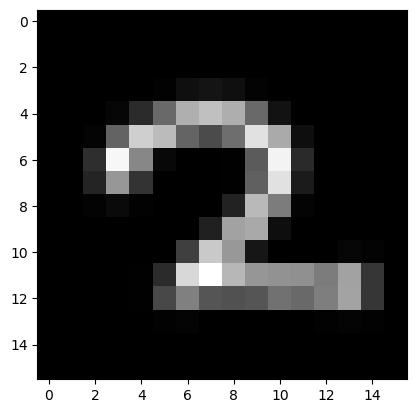

In [14]:
# The image for the fourth data element
show_data(validation_dataset[77])

create a train loader and data loader  object.

In [15]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=5000)

<!--Empty Space for separating topics-->

<h2 id="AE">Differnt type of Autoencders </h2>

In this section, we build autoencoders with different encoding and decoding functions and compare them. To save time  rather than training the model, you can load models.

The following is an auto-encoder class or custom module with one layer.  The parameter <code>D_in </code> is the input dimension, the parameter <code>H </code> is the number of hidden neurons or nodes or the dimension of the encoding dimensions.  This will transform the input into the latent space. The output is sometimes called the code.  The output dimension is the same as the input dimension.

We can create an autoencoder  object the encoding dimension will be three we will visualize the code. 

<b>Linear Autoencoder  </b>
<p>
We have a linear autoencoder, module or class: 
</p>

In [16]:
class AutoEncoder(nn.Module):
    
    # Contructor
    def __init__(self, input_dim=256, encoding_dim=32):
        super(AutoEncoder, self).__init__()
        
        self.encoder = nn.Linear(input_dim,encoding_dim)
        self.decoder = nn.Linear(encoding_dim,input_dim)
    
    # Prediction
    def forward(self, x):
        x =  self.encoder(x)
        
        x=self.decoder(x)
      
        return x

We create an autoencoder object, criterion function and optimizer.


In [17]:
auto_encoder_3  = AutoEncoder(input_dim=tensor_size , encoding_dim=3)
criterion = nn.MSELoss()
learning_rate = 0.001
optimizer = torch.optim.Adam(auto_encoder_3.parameters(), lr = learning_rate)

We train the model using the Root means square error,ff you don't want to train the model, you can load it in the next cell. 

checkpoint={'epoch':None,'model_state_dict':None ,'optimizer_state_dict':None ,'loss': None ,'training_cost':None,'validaion_cost':None }
checkpoint_path='linear_visualization_MIST.pt'
cost_list_training, cost_list_validation=train_model(auto_encoder_3 ,train_loader,validation_loader,optimizer,n_epochs=10,checkpoint_path=checkpoint_path,checkpoint=checkpoint)


You can load the model:

In [26]:
checkpoint={'epoch':None,'model_state_dict':None ,'optimizer_state_dict':None ,'loss': None ,'training_cost':None,'validaion_cost':None }
checkpoint_path='linear_visualization_MIST.pt'
cost_list_training, cost_list_validation = train_model(auto_encoder_3 ,train_loader,validation_loader,optimizer,n_epochs=10,checkpoint_path=checkpoint_path,checkpoint=checkpoint)


epoch 1, Cost 18.258150100708008
epoch 2, Cost 18.218873977661133
epoch 3, Cost 18.186616897583008
epoch 4, Cost 18.16010856628418
epoch 5, Cost 18.1381893157959
epoch 6, Cost 18.120149612426758
epoch 7, Cost 18.10546112060547
epoch 8, Cost 18.092533111572266
epoch 9, Cost 18.082311630249023
epoch 10, Cost 18.073863983154297


we can plot the cost on the training and validation data 

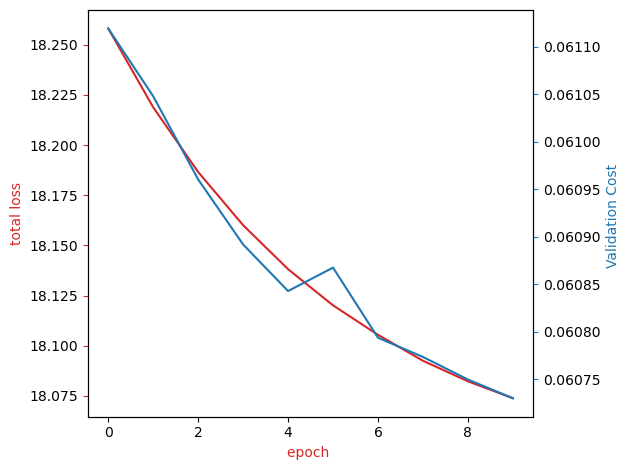

In [27]:
cost_list_training,cost_list_validation=checkpoint['training_cost'], checkpoint['validaion_cost']
plot_train_val(cost_list_training,cost_list_validation,val_data_label ='Validation Cost ')

we can output  the code :

In [28]:
z=auto_encoder_3.encoder(validation_dataset[5][0].view(-1,256))
z

tensor([[ 0.2939,  0.0877, -0.7259]], grad_fn=<AddmmBackward0>)

we can make a prediction, the output is the same shape as the input:

In [29]:
xhat=auto_encoder_3(validation_dataset[5][0].view(-1,256))
print(xhat.shape)

torch.Size([1, 256])


 the class of the input is a one 

In [30]:
validation_dataset[5][1]

1

we can plot the output it looks like a one: 

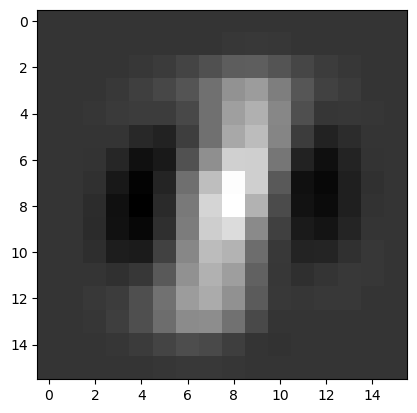

In [31]:
show_data(xhat)

We can plot out the output of the enoding dimension or code, and compare it to the activations of the hidden layer of the neural network. Although there is some overlap, we see that similar to the neural network each cluster corresponds to each class. This result is obtained even though there are no labels in the autoencoder.

/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/matplotlib/collections.py:981: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


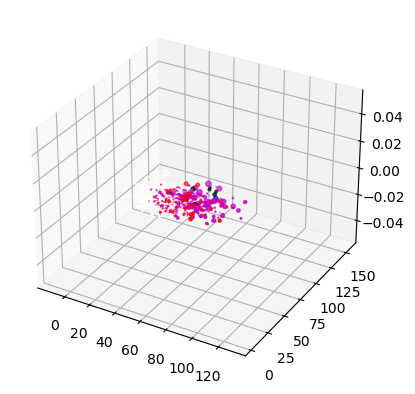

In [34]:
auto_3_act=plot_activations_3d(model_=auto_encoder_3 ,layer_name='encoder',dataset=train_dataset,tensor_size=tensor_size)
auto_3_act.plot(scale=[100,100,100])


<b>Tanh Encoding Function</b>

Autoencoder module or class with Tanh Encoding function:

In [35]:
class AutoEncoderTanh(nn.Module):
    
    # Contructor
    def __init__(self, input_dim=256, encoding_dim=32):
        super(AutoEncoderTanh, self).__init__()
        
        self.encoder = nn.Linear(input_dim,encoding_dim)
        self.decoder = nn.Linear(encoding_dim,input_dim)
    
    # Prediction
    def forward(self, x):
        x =  torch.tanh(self.encoder(x))
        
        x=self.decoder(x)
      
        return x
    def code(self,x):
        return torch.tanh(self.encoder(x))

We create an autoencoder object, criterion function and optimizer.

In [36]:
auto_encoder_tanh = AutoEncoderTanh(input_dim=tensor_size , encoding_dim=3)
criterion = nn.MSELoss()
learning_rate = 0.001
optimizer = torch.optim.Adam(auto_encoder_tanh.parameters(), lr = learning_rate)

We train the model using the Root means square error,ff you don't want to train the model, you can load it in the next cell.

checkpoint={'epoch':None,'model_state_dict':None ,'optimizer_state_dict':None ,'loss': None ,'training_cost':None,'validaion_cost':None }
checkpoint_path='tan_linear_out_visualization_MIST.pt'
cost_list_training, cost_list_validation=train_model(auto_encoder_tanh ,train_loader,validation_loader,optimizer,n_epochs=10,checkpoint_path=checkpoint_path,checkpoint=checkpoint)


we load the trained model

In [37]:
checkpoint={'epoch':None,'model_state_dict':None ,'optimizer_state_dict':None ,'loss': None ,'training_cost':None,'validaion_cost':None }
checkpoint_path='tan_linear_out_visualization_MIST.pt'
cost_list_training, cost_list_validation=train_model(auto_encoder_tanh ,train_loader,validation_loader,optimizer,n_epochs=10,checkpoint_path=checkpoint_path,checkpoint=checkpoint)

epoch 1, Cost 47.05362319946289
epoch 2, Cost 23.910959243774414
epoch 3, Cost 22.569820404052734
epoch 4, Cost 21.1436710357666
epoch 5, Cost 19.95047950744629
epoch 6, Cost 19.124290466308594
epoch 7, Cost 18.650875091552734
epoch 8, Cost 18.406299591064453
epoch 9, Cost 18.279098510742188
epoch 10, Cost 18.209781646728516


we can plot the cost on the training and validation data 

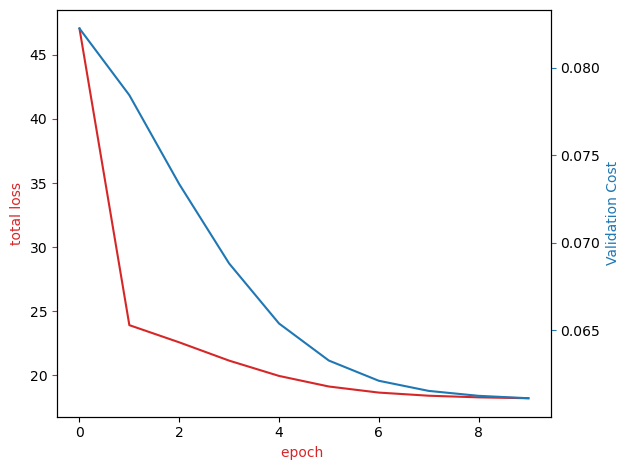

In [38]:
cost_list_training,cost_list_validation=checkpoint['training_cost'], checkpoint['validaion_cost']
plot_train_val(cost_list_training,cost_list_validation,val_data_label ='Validation Cost')

we can obtain the code:

In [39]:
z=auto_encoder_tanh.encoder(validation_dataset[5][0].view(-1,256))
z

tensor([[ 0.0578, -0.4167,  0.0300]], grad_fn=<AddmmBackward0>)

we can make a prediction, the output is the same shape as the input convert it to a rectangle image a view it:

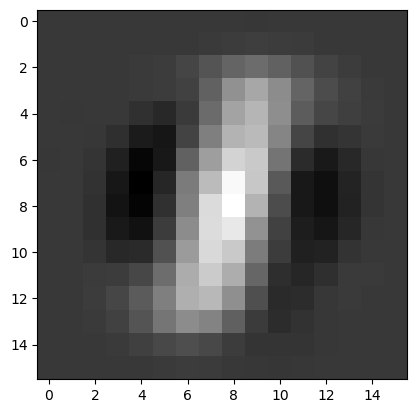

In [40]:
xhat=auto_encoder_tanh(validation_dataset[5][0].view(-1,256))
show_data(xhat)

We can plot out the output of the latent  dimension or code:

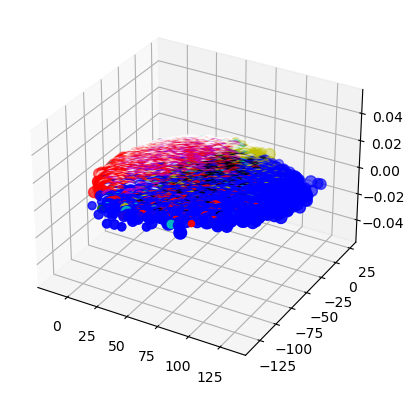

In [41]:
auto_3_act=plot_activations_3d(model_=auto_encoder_tanh ,layer_name='encoder',dataset=train_dataset,tensor_size=tensor_size)
auto_3_act.plot(scale=[100,100,100])

we see that all the clusters are segmented with respect to each class.

<b>Autoencoder Tanh Encoding and Decoding Function </b> 

We create an Autoencoder module or class with Tanh Encoding and Decoding function.  

In [42]:
class AutoEncoderTanhDecoder(nn.Module):
    
    # Contructor
    def __init__(self, input_dim=256, encoding_dim=32):
        super(AutoEncoderTanhDecoder, self).__init__()
        
        self.encoder = nn.Linear(input_dim,encoding_dim)
        self.decoder = nn.Linear(encoding_dim,input_dim)
    
    # Prediction
    def forward(self, x):
        x =  torch.tanh(self.encoder(x))
        
        x=torch.tanh(self.decoder(x))
      
        return x

We can apply the tanh encoding function. We can plot the code; we see the clusters with respect  to each class is more apparent than a linear autoencoder. It’s difficult to say if the clusters are more visible than the autoencoder with the tanh encoding function and linear output.   

In [43]:
auto_encoder_tanh_D = AutoEncoderTanhDecoder(input_dim=tensor_size , encoding_dim=3)
criterion = nn.MSELoss()
learning_rate = 0.001
optimizer = torch.optim.Adam(auto_encoder_tanh_D.parameters(), lr = learning_rate)

We train the model using the Root means a square error,ff you don't want to train the model, you can load it in the next cell.

checkpoint={'epoch':None,'model_state_dict':None ,'optimizer_state_dict':None ,'loss': None ,'training_cost':None,'validaion_cost':None }
checkpoint_path='auto_encoder_tanh_in_out.pt'
cost_list_training, cost_list_validation=train_model(auto_encoder_tanh_D ,train_loader,validation_loader,optimizer,n_epochs=10,checkpoint_path=checkpoint_path,checkpoint=checkpoint)

we can load the model from memory:

we can load the model 

In [44]:
checkpoint={'epoch':None,'model_state_dict':None ,'optimizer_state_dict':None ,'loss': None ,'training_cost':None,'validaion_cost':None }
checkpoint_path='auto_encoder_tanh_in_out.pt'
cost_list_training, cost_list_validation=train_model(auto_encoder_tanh_D ,train_loader,validation_loader,optimizer,n_epochs=10,checkpoint_path=checkpoint_path,checkpoint=checkpoint)

epoch 1, Cost 40.964847564697266
epoch 2, Cost 24.207910537719727
epoch 3, Cost 22.580154418945312
epoch 4, Cost 20.712690353393555
epoch 5, Cost 19.60112762451172
epoch 6, Cost 19.013212203979492
epoch 7, Cost 18.715927124023438
epoch 8, Cost 18.550762176513672
epoch 9, Cost 18.440134048461914
epoch 10, Cost 18.35808753967285


we can plot the results :

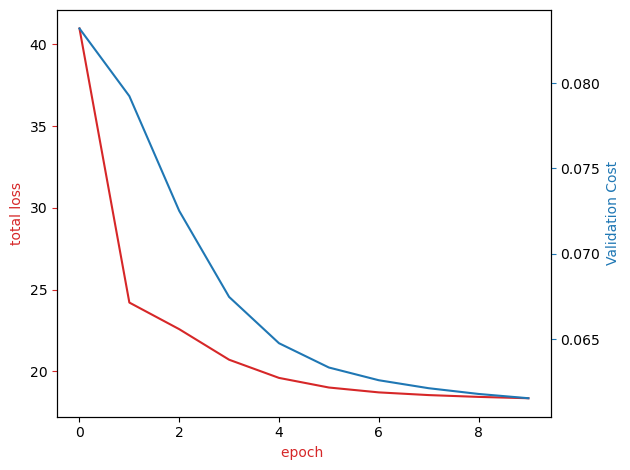

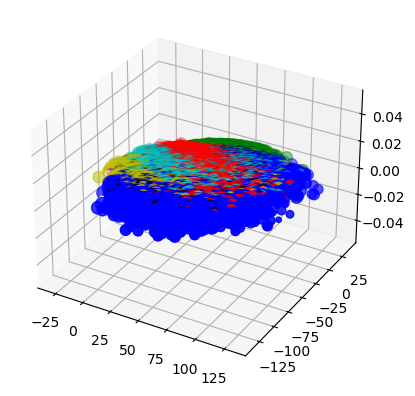

In [45]:
cost_list_training,cost_list_validation=checkpoint ['training_cost'], checkpoint['validaion_cost']
plot_train_val(cost_list_training,cost_list_validation,val_data_label ='Validation Cost')
auto_3_act=plot_activations_3d(model_=auto_encoder_tanh_D ,layer_name='encoder',dataset=train_dataset,tensor_size=tensor_size)
auto_3_act.plot(scale=[100,100,100])

One issue with a non-linear autoencoder is the output are not real numbers. For example with the tanh function the output will range from -1 and 1. We can see the output is difficult to see.   

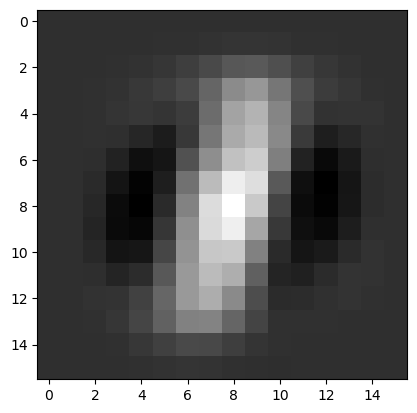

In [46]:
xhat=auto_encoder_tanh_D(validation_dataset[5][0].view(-1,256))
show_data(xhat)

<h2>About the Authors:</h2> 

<a href="https://www.linkedin.com/in/joseph-s-50398b136/">Joseph Santarcangelo</a> has a PhD in Electrical Engineering, his research focused on using machine learning, signal processing, and computer vision to determine how videos impact human cognition. Joseph has been working for IBM since he completed his PhD.

<hr>

Copyright &copy; 2020 <a href="cognitiveclass.ai?utm_source=bducopyrightlink&utm_medium=dswb&utm_campaign=bdu">cognitiveclass.ai</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.